In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

df = pd.read_csv('../data/data.csv')

In [13]:
cols = [
    "close_ma_30", 
    "close_ma_90", 
    "close_ma_200", 
    "volume_ma_30", 
    "volume_ma_90", 
    "volume_ma_200", 
    "currentRatio_ma", 
    "quickRatio_ma", 
    "returnOnEquity_ma", 
    "returnOnAssets_ma", 
    "netProfitMargin_ma", 
    "priceEarningsRatio_ma", 
    "priceBookValueRatio_ma", 
    "priceToSalesRatio_ma", 
    "freeCashFlowPerShare_ma", 
    "operatingCashFlowPerShare_ma", 
    "cashFlowToDebtRatio_ma", 
    "debtEquityRatio_ma", 
    "longTermDebtToCapitalization_ma", 
    "assetTurnover_ma", 
    "inventoryTurnover_ma"
]


scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols]))
df_scaled.columns = cols

# concat scaled colums

df = df.drop(cols, axis=1)
df_scaled = pd.concat([df, df_scaled], axis=1)

In [17]:
df_scaled.to_csv('../data/data_scaled.csv', index=False)

In [ ]:
# log transform everything

cols = list(df_scaled.columns)
cols.pop(0)

df_scaled.fillna(method='ffill', inplace=True)
df_log = np.log1p(df_scaled[cols] + 1e-6)
df_log.fillna(method='ffill', inplace=True)
df_log['symbol'] = df_scaled['symbol']

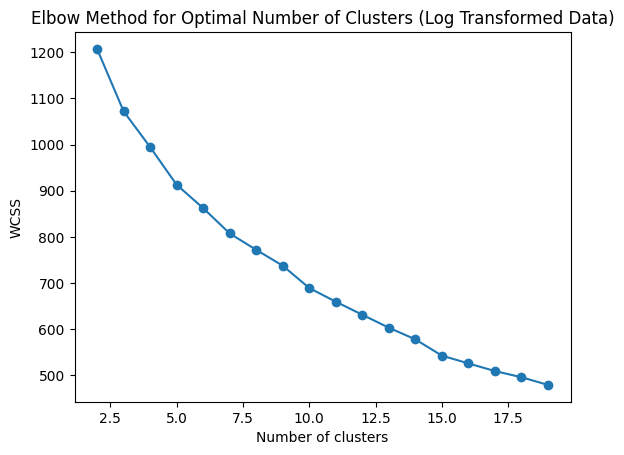

In [50]:
wcss_log = []
range_n_clusters = list(range(2, 20))

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(df_log[cols])
    wcss_log.append(kmeans.inertia_)

plt.plot(range_n_clusters, wcss_log, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters (Log Transformed Data)')
plt.show()

In [54]:
# test for 6 clusters

kmeans_6 = KMeans(n_clusters=6, random_state=42, n_init=10)
df_log['cluster_6'] = kmeans_6.fit_predict(df_log[cols])

clusters_by_symbol_6 = df_log[['symbol', 'cluster_6']]
clusters_by_symbol_6

,symbol,cluster_6
0,APO,1
1,LII,5
2,WDAY,2
3,TPL,5
4,DELL,1
...,...,...
495,PPG,1
496,RTX,3
497,SLB,4
498,SO,1


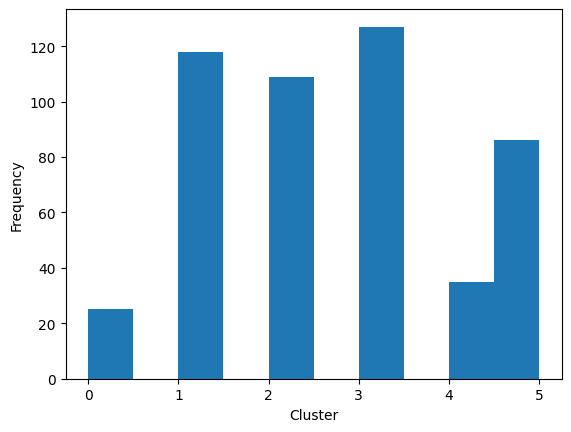

In [58]:
plt.hist(df_log['cluster_6'])
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()